In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from pydub import AudioSegment
import time

import pyaudio
import wave

from pyannote.core import Annotation, Segment
from pyannote.audio.pipelines import VoiceActivityDetection

In [2]:
silence_detection_pipeline = VoiceActivityDetection(segmentation="pyannote/segmentation")
HYPER_PARAMETERS = {
  # onset/offset activation thresholds
  "onset": 0.5, "offset": 0.5,
  # remove speech regions shorter than that many seconds.
  "min_duration_on": 0.0,
  # fill non-speech regions shorter than that many seconds.
  "min_duration_off": 0.0
}
silence_detection_pipeline.instantiate(HYPER_PARAMETERS)

In [6]:
ejemplo = 0

In [79]:
ejemplo += 1

t0 = time.time()

# =========================================
# Parameters audio recording 
# =========================================
CHUNK = 1024
CHANNELS = 1
RATE = 48000 # 44100
FORMAT = pyaudio.paInt32 # pyaudio.paInt16, pyaudio.paInt24, pyaudio.paInt32
RECORD_SECONDS = 30 # Maximum recording time
TIME_TO_CUT = 1.5 # Time threshold for considering the end of the speech
WAVE_OUTPUT_FILENAME = "voice_"+str(ejemplo)+".wav"

# Start streaming
p = pyaudio.PyAudio()
stream = p.open(format=FORMAT, channels=CHANNELS,
                rate=RATE, input=True, frames_per_buffer=CHUNK)
print("* recording")
t0_start_talk = time.time()

silence_th = 0
frames = []

# Crear y guardar un archivo vacío para acerlerar el guardado posterior
wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
wf.setparams((CHANNELS, p.get_sample_size(FORMAT), RATE, 0, 'NONE', 'not compressed'))
wf.writeframes(b''.join(frames))
wf.close()

# Bucle hasta un máximo de RECORD_SECONDS segundos       
for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data)
    
    # Guardar a partir del primer segundo 
    if time.time()-t0_start_talk > 2:
        
        wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
        wf.setnchannels(CHANNELS)
        wf.setsampwidth(p.get_sample_size(FORMAT))
        wf.setframerate(RATE)
        wf.writeframes(b''.join(frames))
        wf.close()
        
        vad = silence_detection_pipeline(WAVE_OUTPUT_FILENAME)
        
        x = vad.get_timeline().segments_set_
        
        if len(x) > 0:
            # Coger el tiempo final del ultimo segmento detectado
            last_time_talk = np.max([x_elt.end for x_elt in list(x)]) 
            # Comparar con el instante actual y ver si supera el umbral de tiempo
            if time.time()-(last_time_talk+t0_start_talk) > TIME_TO_CUT: # Por que?? time.time()-(last_time_talk+t0_start_talk)
                print('Duration:',round(time.time()-(last_time_talk+t0_start_talk),2))
                break
            else:
                silence_th += len(x) - 1
        
        t0 = time.time()
wf.close()
print("* done recording")

stream.stop_stream()
stream.close()
p.terminate()

wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(frames))
wf.close()

* recording
Duration: 1.51
* done recording


In [70]:
x

{<Segment(0.885938, 1.96594)>}

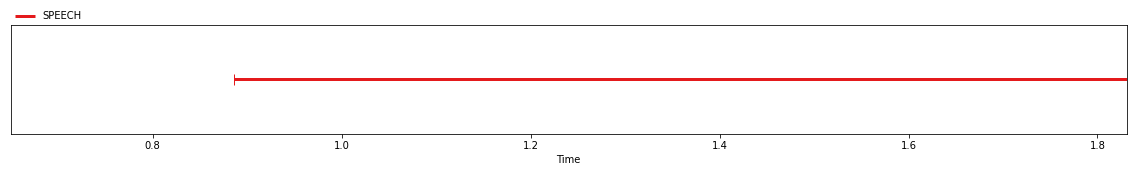

In [72]:
VAD = silence_detection_pipeline(WAVE_OUTPUT_FILENAME)
VAD